In [1]:
from pprint import pprint

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Set Seaborn theme and default palette
sns.set_context("talk")
sns.set_theme(font_scale=1.25, style="whitegrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from ndg_tools import plotting
from ndg_tools.sklearn.vectorizers import FreqVectorizer

FIT_MODEL = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<IPython.core.display.Javascript object>


# Modeling
## Loading the Data

In [3]:
# Load training data
df = pd.read_parquet("data/model_data", engine="pyarrow")

# Shuffle for good measure
df = df.sample(frac=1, random_state=68)

df.head()

text  \
asin                                                            
B000FQFC4S  chicago_cutlery metropolitan pc_set metropolit...   
B01F8GU532  brand_new idle_air control_valve iac ford_oem ...   
B00O9WDEJO  uxcell screw type furniture level foot adjuste...   
B000P1OZ2S  plug_play video paintball trainer game hasbro ...   
B00FPTGT9C  five_ocean windshield hatch adjuster stainless...   

                                                        title  \
asin                                                            
B000FQFC4S            chicago cutlery metropolitan 10-pc. set   
B01F8GU532  brand new idle air control valve iac for 2001-...   
B00O9WDEJO  uxcell screw on type furniture leveling foot a...   
B000P1OZ2S  plug & play video paintball trainer game by ha...   
B00FPTGT9C  five oceans windshield hatch adjuster, stainle...   

                      brand           main_cat  
asin                                            
B000FQFC4S  chicago_cutlery        amazon home  
B01F8GU532  aip_electronics         automotive  
B00O9WDEJO           uxcell        amazon home  
B000P1OZ2S           hasbro       toys & games  
B00FPTGT9C      five_oceans  sports & outdoors

<IPython.core.display.Javascript object>

In [4]:
X = df.loc[:, "text"]
y = df.loc[:, "main_cat"]

X.shape, y.shape

((1072953,), (1072953,))

<IPython.core.display.Javascript object>

In [5]:
best_pipe = joblib.load("models/svm_3.joblib")

# Set lowercase just to be sure
best_pipe["vec"].set_params(lowercase=True)


best_pipe

Pipeline(steps=[('vec', TfidfVectorizer(binary=True, token_pattern='\\S+')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [6]:
demo_pipe = joblib.load("models/svm_2.joblib")

# Set lowercase just to be sure
demo_pipe["vec"].set_params(lowercase=True)

demo_pipe

Pipeline(steps=[('vec', TfidfVectorizer(binary=True, token_pattern='\\S+')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [7]:
def extract_coef(
    best_pipeline,
    classifier="cls",
    vectorizer="vec",
):
    """Returns labeled model coefficients as a DataFrame."""
    columns = np.array(best_pipeline[vectorizer].get_feature_names_out())
    coef = pd.DataFrame(
        best_pipeline[classifier].coef_,
        index=best_pipeline[classifier].classes_,
        columns=columns,
    ).T
    return coef

<IPython.core.display.Javascript object>

## Refitting the Best Model

Next I refit the model on the full `X`.

In [8]:
if FIT_MODEL:
    # Train on full X
    best_pipe.fit(X, y)
    joblib.dump(best_pipe, "models/final_refit.joblib", compress=True)

else:
    # Load the saved model
    best_pipe = joblib.load("models/final_refit.joblib")
best_pipe

Pipeline(steps=[('vec', TfidfVectorizer(binary=True, token_pattern='\\S+')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [9]:
len(best_pipe["vec"].get_feature_names_out())

630298

<IPython.core.display.Javascript object>

In [10]:
coef = extract_coef(best_pipe)
coef = coef.sort_values("video games", ascending=False)
coef.head(10)

all beauty  all electronics  amazon devices  amazon fashion  \
cta_digital      -0.023562        -1.856255       -0.785085       -0.081385   
ubisoft          -0.091247        -0.449539       -0.009350       -0.141588   
electronic_art   -0.070444        -0.809814        0.000000       -0.141806   
activision       -0.059537        -0.383885       -0.093731       -0.115115   
atari            -0.028304        -0.716843        0.000000       -0.057033   
mad_catz          0.000000        -1.779826       -0.037964        0.000000   
sega             -0.082176        -0.336839        0.000000       -0.030425   
nintendo         -0.383398        -1.642656       -0.810899       -0.254870   
thq              -0.016096        -0.335580       -0.005703       -0.009212   
screenseven       0.000000        -0.104461        0.000000       -0.123583   

                amazon home  appliances  arts, crafts & sewing  automotive  \
cta_digital       -0.674240   -0.012864              -0.059633   -0.568618   
ubisoft           -0.392807   -0.003339              -0.077250   -0.282521   
electronic_art    -1.231323   -0.049352               0.000000   -0.285917   
activision        -0.108779   -0.004723               0.000000   -0.309400   
atari             -0.131045    0.000000               0.000000   -0.244798   
mad_catz          -0.289604    0.000000              -0.069371   -0.066402   
sega              -0.109894   -0.025828              -0.057792   -0.032766   
nintendo          -0.501677   -0.018395              -0.077596   -0.247576   
thq               -0.018406    0.000000               0.000000   -0.390649   
screenseven       -0.194186    0.000000               0.000000    0.000000   

                    baby     books  ...  musical instruments  office products  \
cta_digital    -0.020630  0.000000  ...            -0.799868        -0.384685   
ubisoft         0.000000 -2.369903  ...            -0.391978        -0.195290   
electronic_art -0.018403 -2.272517  ...            -0.024927        -0.239793   
activision     -0.015780 -2.301665  ...            -0.705937        -0.067993   
atari          -0.051685 -1.505908  ...            -0.176650         0.000000   
mad_catz        0.000000  0.000000  ...            -2.388520        -0.036392   
sega           -0.024124 -1.839057  ...            -0.104119        -0.142069   
nintendo       -0.093275 -1.312605  ...            -0.663016        -0.483398   
thq            -0.056771 -1.829273  ...            -0.184477        -0.011361   
screenseven     0.000000 -1.928766  ...            -0.084800         0.000000   

                pet supplies  portable audio & accessories  prime pantry  \
cta_digital        -0.036159                     -0.239881      0.000000   
ubisoft            -0.452646                      0.000000     -0.012135   
electronic_art     -0.495263                      0.000000      0.000000   
activision         -0.560977                     -0.012327     -0.010439   
atari              -0.086728                      0.000000     -0.129104   
mad_catz            0.000000                     -0.053139      0.000000   
sega               -0.050048                     -0.007824      0.000000   
nintendo           -0.152219                     -0.283972     -0.130172   
thq                -1.073015                      0.000000      0.000000   
screenseven         0.000000                     -0.016953     -0.048629   

                software  sports & outdoors  tools & home improvement  \
cta_digital    -0.009764          -1.771304                 -0.495676   
ubisoft        -2.638562          -0.722595                 -0.110198   
electronic_art -2.238792          -2.049987                 -0.282404   
activision     -1.989176          -2.473567                 -0.353858   
atari          -2.584624          -1.426665                 -0.030729   
mad_catz       -0.041354          -1.422476                 -0.150416   
sega           -0.830407          -1.842073    

<IPython.core.display.Javascript object>

## Refitting the Demo Model

In [11]:
if FIT_MODEL:
    # Train on full X
    demo_pipe.fit(X, y)
    joblib.dump(best_pipe, "models/demo_refit.joblib", compress=True)

else:
    # Load the saved model
    demo_pipe = joblib.load("models/demo_refit.joblib")
demo_pipe

Pipeline(steps=[('vec', TfidfVectorizer(binary=True, token_pattern='\\S+')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [12]:
demo_coef = extract_coef(demo_pipe)
demo_coef = demo_coef.sort_values("video games", ascending=False)
demo_coef.head(10)

all beauty  all electronics  amazon devices  amazon fashion  \
electronic_art   -0.118897        -0.708550       -0.017340       -0.120721   
cta_digital       0.000000        -1.806073       -0.182118       -0.050828   
activision        0.000000        -0.360576       -0.031953       -0.075812   
ubisoft          -0.266196        -0.566781       -0.019011       -0.125219   
mad_catz          0.000000        -1.764788        0.000000        0.000000   
atari             0.000000        -0.675236        0.000000       -0.070416   
sega             -0.043388        -0.396370       -0.012926       -0.035425   
thq               0.000000        -0.317088        0.000000       -0.025042   
nintendo         -0.219365        -1.729017       -0.467380       -0.292264   
screenseven       0.000000        -0.072017        0.000000       -0.091661   

                amazon home  appliances  arts, crafts & sewing  automotive  \
electronic_art    -1.261561    0.000000              -0.022317   -0.262240   
cta_digital       -0.625244    0.000000              -0.050813   -0.538220   
activision        -0.066325    0.000000               0.000000   -0.386089   
ubisoft           -0.271962    0.000000              -0.046796   -0.141662   
mad_catz          -0.413775   -0.026151              -0.049138   -0.154585   
atari             -0.187960    0.000000              -0.031637   -0.237086   
sega              -0.202899    0.000000               0.000000   -0.001763   
thq               -0.037499    0.000000               0.000000   -0.368971   
nintendo          -0.480114   -0.028823              -0.076823   -0.243241   
screenseven       -0.164771    0.000000               0.000000    0.000000   

                    baby     books  ...  musical instruments  office products  \
electronic_art  0.000000 -2.198816  ...            -0.042230        -0.238973   
cta_digital     0.000000  0.000000  ...            -0.753621        -0.362530   
activision     -0.024688 -2.410014  ...            -0.716579        -0.078607   
ubisoft        -0.054277 -2.296784  ...            -0.466721        -0.190632   
mad_catz        0.000000  0.000000  ...            -2.512886        -0.056483   
atari           0.000000 -1.546576  ...            -0.192913        -0.078855   
sega           -0.073745 -1.950073  ...            -0.106277        -0.054092   
thq            -0.073021 -1.928930  ...            -0.066631         0.000000   
nintendo       -0.125186 -1.420546  ...            -0.745795        -0.456885   
screenseven     0.000000 -2.044330  ...             0.000000         0.000000   

                pet supplies  portable audio & accessories  prime pantry  \
electronic_art     -0.499444                      0.000000      0.000000   
cta_digital         0.000000                     -0.203785      0.000000   
activision         -0.504567                      0.000000      0.000000   
ubisoft            -0.404741                      0.000000      0.000000   
mad_catz            0.000000                      0.000000      0.000000   
atari               0.000000                      0.000000     -0.042706   
sega                0.000000                      0.000000      0.000000   
thq                -1.244702                      0.000000      0.000000   
nintendo           -0.180629                     -0.283549     -0.022916   
screenseven         0.000000                      0.000000      0.000000   

                software  sports & outdoors  tools & home improvement  \
electronic_art -2.149718          -2.059166                 -0.234223   
cta_digital     0.000000          -1.809785                 -0.576417   
activision     -2.015919          -2.449856                 -0.370099   
ubisoft        -2.669316          -0.748451                 -0.052337   
mad_catz       -0.111185          -1.295928                 -0.093711   
atari          -2.460226          -1.349154                  0.000000   
sega           -0.710272          -1.799382    

<IPython.core.display.Javascript object>

<AxesSubplot:>

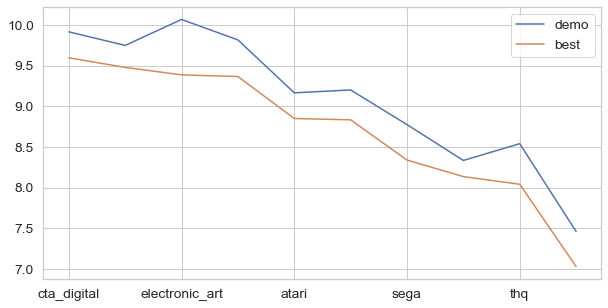

<IPython.core.display.Javascript object>

In [13]:
comparison = (
    demo_coef.reindex_like(coef)
    .compare(coef)
    .rename({"self": "demo", "other": "best"}, axis=1)
)
comparison["video games"].head(10).plot.line(figsize=(10, 5))

In [14]:
rng = np.random.default_rng(55)

cmaps = [
    "Purples",
    "Blues",
    "Greens",
    "Oranges",
    "Reds",
    "YlOrBr",
    "YlOrRd",
    "OrRd",
    "PuRd",
    "RdPu",
    "BuPu",
    "GnBu",
    "PuBu",
    "YlGnBu",
    "PuBuGn",
    "BuGn",
    "YlGn",
]
cmaps = rng.choice(cmaps, coef.columns.size).tolist()
cmaps

['YlGn',
 'PuBuGn',
 'PuBu',
 'PuBuGn',
 'Oranges',
 'Oranges',
 'YlGnBu',
 'Oranges',
 'BuPu',
 'PuRd',
 'YlOrBr',
 'PuBu',
 'PuRd',
 'GnBu',
 'Blues',
 'YlGn',
 'YlGnBu',
 'Blues',
 'GnBu',
 'PuRd',
 'YlOrRd',
 'YlOrBr',
 'YlOrRd',
 'BuPu',
 'Purples',
 'Purples',
 'OrRd',
 'YlOrBr',
 'GnBu',
 'Blues',
 'PuRd',
 'YlGn',
 'YlGn',
 'BuPu',
 'Reds',
 'PuRd']

<IPython.core.display.Javascript object>

## Plotting the Best Model Coefficients

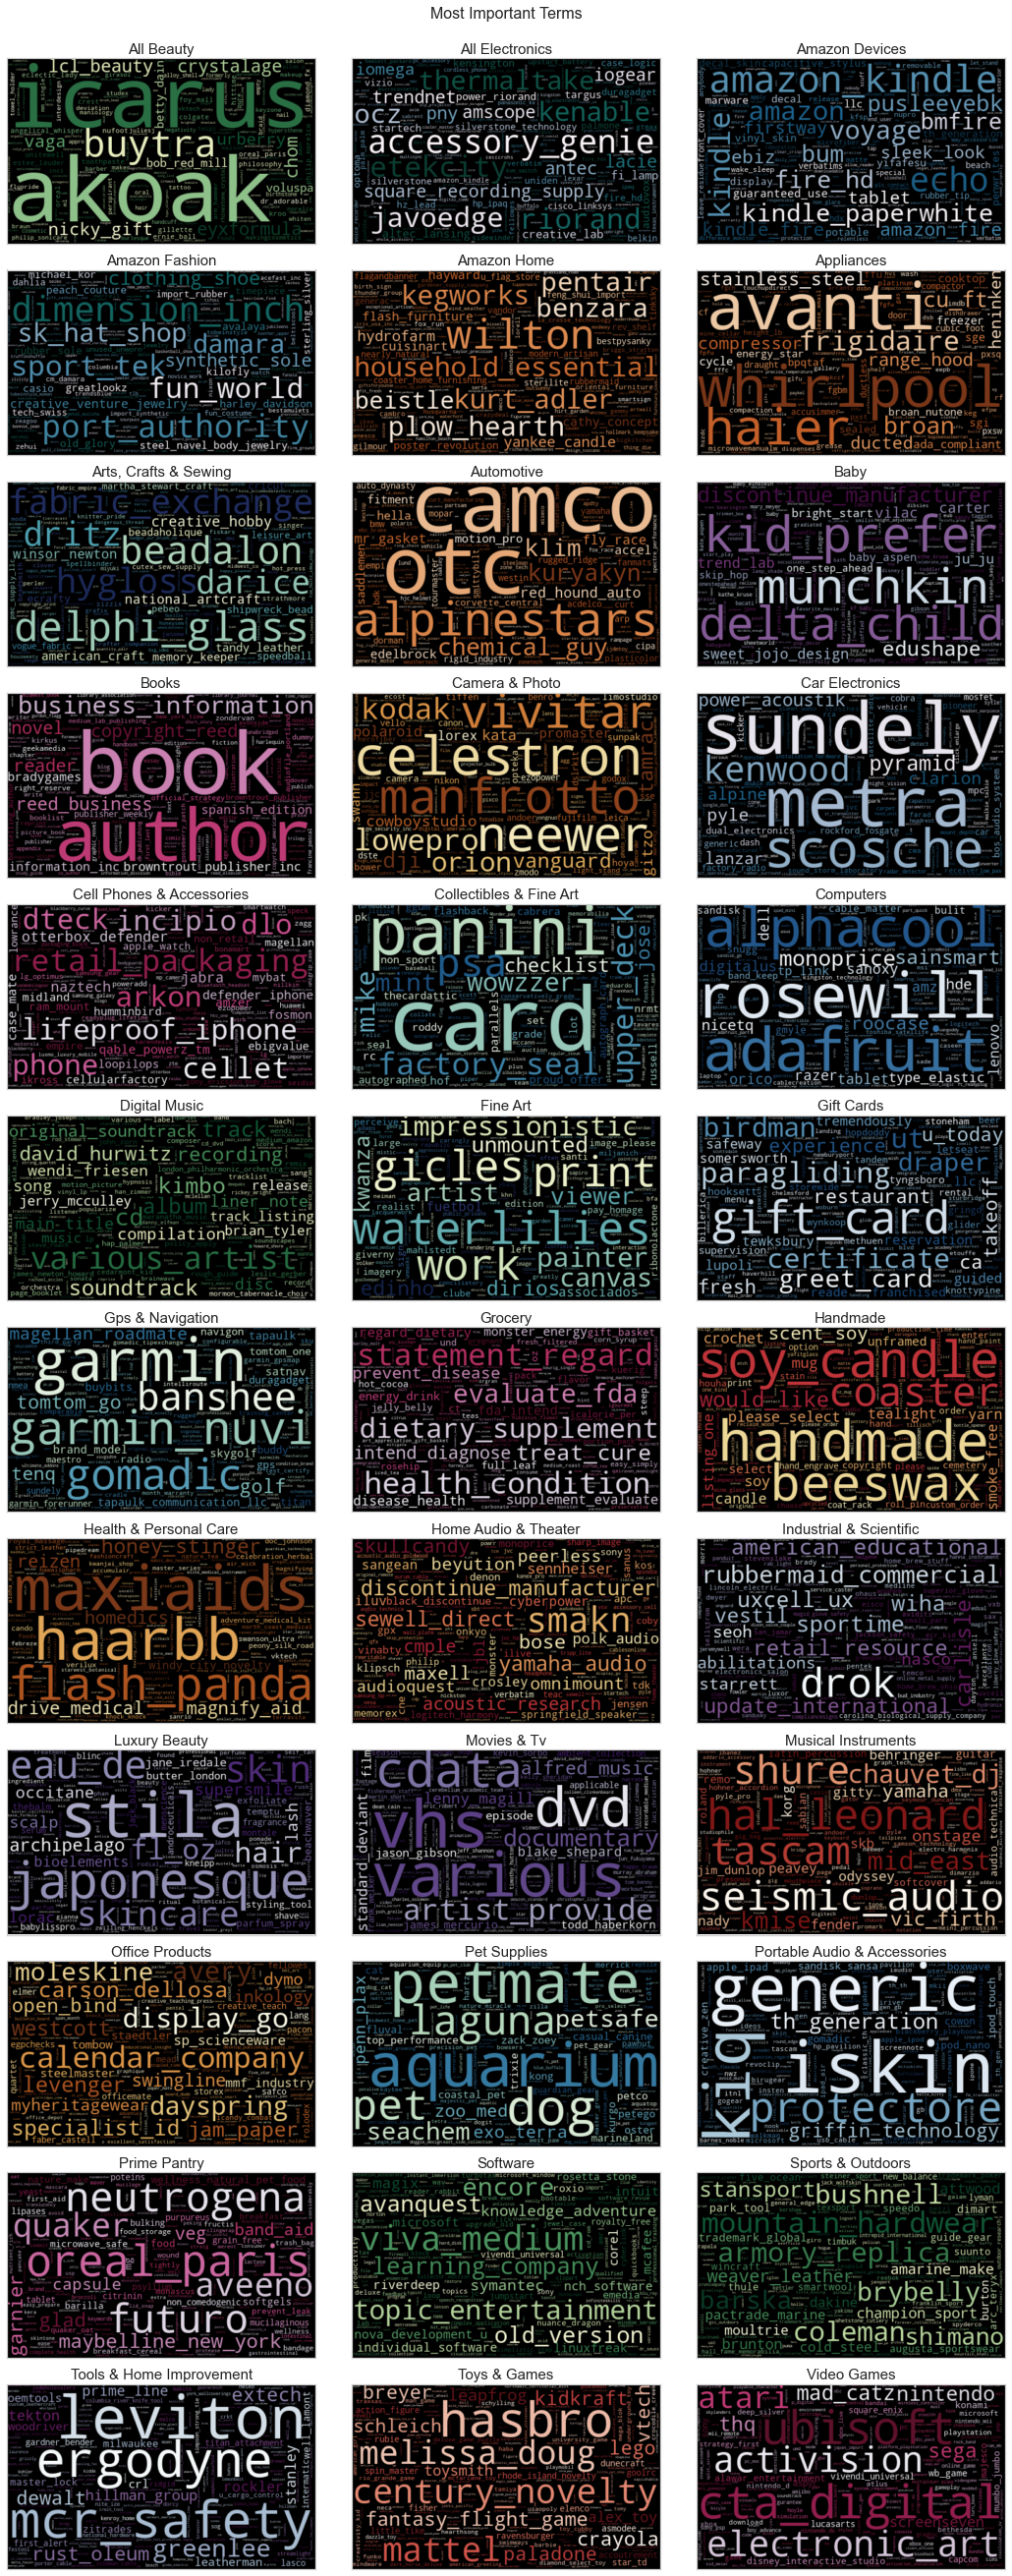

<IPython.core.display.Javascript object>

In [15]:
coef.columns = coef.columns.str.title()
fig = plotting.wordcloud(
    coef,
    cmap=cmaps,
)
fig.suptitle("Most Important Terms", y=1.01, fontsize=16)
fig.savefig("figures/final_refit_coef.svg", bbox_inches="tight")

## Deploying the Best Model

In [16]:
ngrams = [tuple(w.split("_")) for w in best_pipe["vec"].vocabulary_.keys() if "_" in w]
max(map(len, ngrams))

6

<IPython.core.display.Javascript object>

In [17]:
if not isinstance(best_pipe.steps[0], FreqVectorizer):
    fv = FreqVectorizer.from_sklearn(best_pipe["vec"])
    best_pipe.steps[0] = ("vec", fv)
best_pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, norm='l2', token_pattern='\\S+',
                                use_idf=True)),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [18]:
stop_words = set(pd.read_json("canonical_params/stopwords.json", typ="series"))
pprint(stop_words, compact=True)

{'about', 'above', 'additional', 'address', 'addresses', 'after', 'again',
 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'apo', 'are', 'aren', 'as',
 'asin', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'best',
 'between', 'both', 'but', 'buy', 'by', 'can', 'cash', 'com', 'couldn',
 'customer', 'deal', 'deliver', 'delivered', 'delivery', 'detail', 'did',
 'didn', 'dimensions', 'discontinued', 'do', 'does', 'doesn', 'doing', 'don',
 'down', 'during', 'each', 'eligible', 'feature', 'few', 'for', 'fpo', 'from',
 'further', 'guarantee', 'had', 'hadn', 'has', 'hasn', 'have', 'haven',
 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his',
 'how', 'if', 'in', 'into', 'is', 'isn', 'it', 'item', 'its', 'itself', 'just',
 'listed', 'll', 'ma', 'me', 'mightn', 'money', 'more', 'most', 'mustn', 'my',
 'myself', 'na', 'needn', 'no', 'none', 'nor', 'not', 'now', 'of', 'off', 'on',
 'once', 'only', 'or', 'other', 'ounce', 'ounces', 'our', 'ours', 'ourselves',


<IPython.core.display.Javascript object>

In [19]:
deploy_params = {
    "lowercase": True,
    "stop_words": stop_words,
    "strip_accents": "ascii",
    "strip_html_tags": True,
    "strip_punct": "_",
    "uniq_char_thresh": 0.375,
    "stemmer": "wordnet",
    "token_pattern": "(?i)\\b[a-z_]{2,16}\\b",
    "ngram_range": (1, 6),
}
deploy_params

{'lowercase': True,
 'stop_words': {'about',
  'above',
  'additional',
  'address',
  'addresses',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'apo',
  'are',
  'aren',
  'as',
  'asin',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'best',
  'between',
  'both',
  'but',
  'buy',
  'by',
  'can',
  'cash',
  'com',
  'couldn',
  'customer',
  'deal',
  'deliver',
  'delivered',
  'delivery',
  'detail',
  'did',
  'didn',
  'dimensions',
  'discontinued',
  'do',
  'does',
  'doesn',
  'doing',
  'don',
  'down',
  'during',
  'each',
  'eligible',
  'feature',
  'few',
  'for',
  'fpo',
  'from',
  'further',
  'guarantee',
  'had',
  'hadn',
  'has',
  'hasn',
  'have',
  'haven',
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'if',
  'in',
  'into',
  'is',
  'isn',
  'it',
  'item',
  'its',
  'itself',
  'just',
  'listed',
  'll',
  'ma',
  'me',
  

<IPython.core.display.Javascript object>

In [20]:
best_pipe["vec"].set_params(**deploy_params)

FreqVectorizer(binary=True, ngram_range=(1, 6), norm='l2', stemmer='wordnet',
               stop_words={'about', 'above', 'additional', 'address',
                           'addresses', 'after', 'again', 'against', 'ain',
                           'all', 'am', 'an', 'and', 'any', 'apo', 'are',
                           'aren', 'as', 'asin', 'at', 'be', 'because', 'been',
                           'before', 'being', 'below', 'best', 'between',
                           'both', 'but', ...},
               strip_accents='ascii', strip_html_tags=True, strip_punct='_',
               token_pattern='(?i)\\b[a-z_]{2,16}\\b', uniq_char_thresh=0.375,
               use_idf=True)

<IPython.core.display.Javascript object>

In [21]:
joblib.dump(best_pipe, "models/final_deploy.joblib", compress=("lz4", 3))
best_pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, ngram_range=(1, 6), norm='l2',
                                stemmer='wordnet',
                                stop_words={'about', 'above', 'additional',
                                            'address', 'addresses', 'after',
                                            'again', 'against', 'ain', 'all',
                                            'am', 'an', 'and', 'any', 'apo',
                                            'are', 'aren', 'as', 'asin', 'at',
                                            'be', 'because', 'been', 'before',
                                            'being', 'below', 'best', 'between',
                                            'both', 'but', ...},
                                strip_accents='ascii', strip_html_tags=True,
                                strip_punct='_',
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                uniq_ch

<IPython.core.display.Javascript object>

## Deploying the Demo Model

In [22]:
if not isinstance(demo_pipe.steps[0], FreqVectorizer):
    fv = FreqVectorizer.from_sklearn(demo_pipe["vec"])
    demo_pipe.steps[0] = ("vec", fv)
demo_pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, norm='l2', token_pattern='\\S+',
                                use_idf=True)),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [23]:
demo_pipe["vec"].set_params(**deploy_params)

FreqVectorizer(binary=True, ngram_range=(1, 6), norm='l2', stemmer='wordnet',
               stop_words={'about', 'above', 'additional', 'address',
                           'addresses', 'after', 'again', 'against', 'ain',
                           'all', 'am', 'an', 'and', 'any', 'apo', 'are',
                           'aren', 'as', 'asin', 'at', 'be', 'because', 'been',
                           'before', 'being', 'below', 'best', 'between',
                           'both', 'but', ...},
               strip_accents='ascii', strip_html_tags=True, strip_punct='_',
               token_pattern='(?i)\\b[a-z_]{2,16}\\b', uniq_char_thresh=0.375,
               use_idf=True)

<IPython.core.display.Javascript object>

In [24]:
joblib.dump(demo_pipe, "models/demo_deploy.joblib", compress=("lz4", 3))
demo_pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, ngram_range=(1, 6), norm='l2',
                                stemmer='wordnet',
                                stop_words={'about', 'above', 'additional',
                                            'address', 'addresses', 'after',
                                            'again', 'against', 'ain', 'all',
                                            'am', 'an', 'and', 'any', 'apo',
                                            'are', 'aren', 'as', 'asin', 'at',
                                            'be', 'because', 'been', 'before',
                                            'being', 'below', 'best', 'between',
                                            'both', 'but', ...},
                                strip_accents='ascii', strip_html_tags=True,
                                strip_punct='_',
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                uniq_ch

<IPython.core.display.Javascript object>